## This program generates data - i.e. time series of all state variables - by integrating forward a model of a three-cell neuronal network (2018 august 20).

### For each run, the user must specify 1) the input currents to each cell, and 2) the synapse strengths.

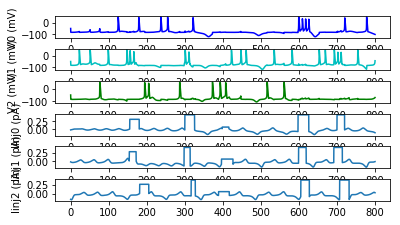

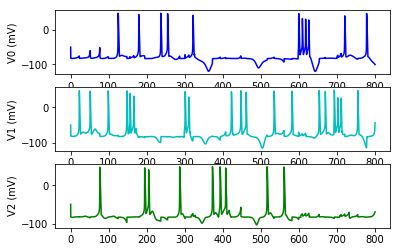

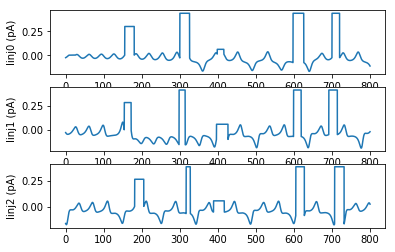

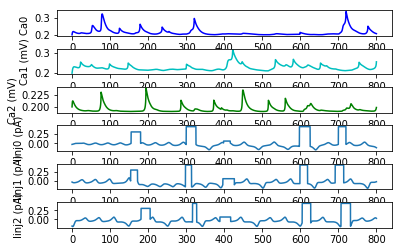

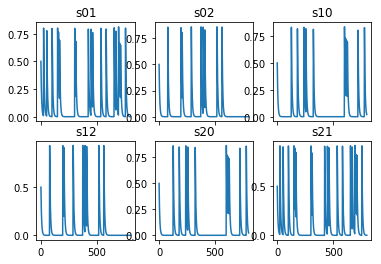

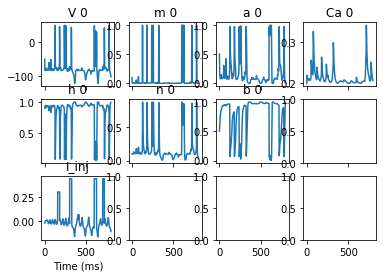

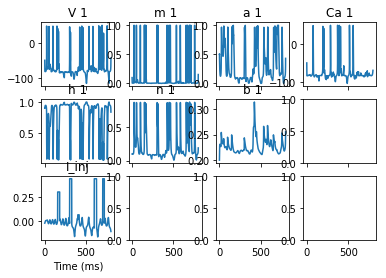

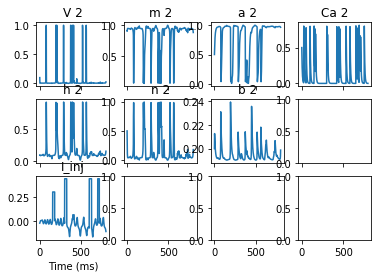

In [2]:
import scipy as sp
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import math

% matplotlib inline

class network:
    def __init__(self):
        self.init = [-50.0, 0.1, 0.9, 0.1, 0.5, 0.5, 0.2, -50.0, 0.1, 0.9, 0.1, 0.5, 0.5, 0.2, \
                     -50.0, 0.1, 0.9, 0.1, 0.5, 0.5, 0.2, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]  # Initial conditions for each variable
        self.Tfinal = 800.   # Final time (ms)
        self.dt = 0.1    # integration time step (ms)

        self.Date = '18aug20'  # to label output files and images
        self.Type = 'chaotic_WLC'  # to label output files and images
#        self.Type = 'chaotic_Q' 
#        self.Type = 'chaotic_g01Zero' 
#        self.Type = 'chaotic_gCaT0Zero' 


        ###
        # INJECTED CURRENTS

        
        ### Chaotic injected currents used to generate data for parameter estimation.
        # Activate these next 6 lines when generating voltage traces to use in DA.
        # De-activate these next 6 lines when generating the active-vs-quiescence modes of activity.
        self.inj1 = sp.loadtxt('injnew1_wStepsHigh2.txt')
        self.inj2 = sp.loadtxt('injnew2_wStepsHigh2.txt')
        self.inj3 = sp.loadtxt('injnew3_wStepsHigh2.txt')

        self.Iscale0 = 160. # Iinj to Cell 0 will be divided by this value.
        self.Iscale1 = 170. # Ditto Cell 1. 
        self.Iscale2 = 180. # Ditto Cell 2.  

        ### Flat injected currents used to elicit the active and quiescent modes of circuit activity.
        # Activate these next 6 lines when generating either mode of activity.  
        # De-activate when generating the voltage traces to use in DA.
#        self.inj1 = sp.loadtxt('current_square.dat')
#        self.inj2 = sp.loadtxt('current_square.dat')
#        self.inj3 = sp.loadtxt('current_square.dat')

#        self.Iscale0 = 0.4 # Iinj to Cell 0 will be divided by this value.
#        self.Iscale1 = 0.5 # Ditto Cell 1.
#        self.Iscale2 = 0.3 # Ditto Cell 2.

        ###
        # MODE OF CIRCUIT
        
        ## QUIESCENCE: Activate these values for 'quiescence' activity.  De-activate for 'active'.
#        self.g00, self.g01, self.g02  = 0.0, 0.025, 0.04   # uS
#        self.g10, self.g11, self.g12 = 0.028, 0.0, 0.018    
#        self.g20, self.g21, self.g22 = 0.021, 0.032, 0.0

        ## ACTIVE: Activate tehse values for 'active' activity.  De-activate for 'quiescence'.
        self.g00, self.g01, self.g02  = 0.0, 0.25, 0.4   # uS
        self.g10, self.g11, self.g12 = 0.28, 0.0, 0.18    
        self.g20, self.g21, self.g22 = 0.21, 0.32, 0.0



        ###
        # PARAMETERS OF INDIVIDUAL CELLS
        self.gL0 = 0.003   # leak max conductance of cell 0
        self.gNa0 = 1.2    # Na max conductance of cell 0
        self.gK0 = 0.20    # K max conductance of cell 0
        self.gL1 = 0.0033  # leak, cell 1 ...
        self.gNa1 = 1.0 
        self.gK1 = 0.22
        self.gL2 = 0.0029
        self.gNa2 = 1.4 
        self.gK2 = 0.17 
        
        self.EL0 = -70.  # Leak reversal potential of cell 0
        self.ENa0 = 50.0 # Leak Na reversal potential of cell 0
        self.EK0 = -77.0  # leak K reversal potential of cell 0
        self.EL1 = -65.5  #Leak reversal potential, cell 1 ...
        self.ENa1 = 50.5 
        self.EK1 = -76.5 
        self.EL2 = -70.5  
        self.ENa2 = 49.5 
        self.EK2 = -76.8 

        self.th_m0 = -40.0 
        self.th_h0 = -60.0 
        self.th_n0 = -55.0 
        self.sig_m0 = 16. 
        self.sig_h0 = -16.
        self.sig_n0 = 25. 
        self.t0_m0 = 0.1 
        self.t0_h0 = 1.0 
        self.t0_n0 = 1.0         
        self.t1_m0 = 0.4 
        self.t1_h0 = 7.0 
        self.t1_n0 = 5.0

        self.th_m1 = -40.5 
        self.th_h1 = -59.5 
        self.th_n1 = -54.5 
        self.sig_m1 = 15.5 
        self.sig_h1 = -15.6  
        self.sig_n1 = 24.5  
        self.t0_m1 = 0.11 
        self.t0_h1 = 1.01 
        self.t0_n1 = 0.99         
        self.t1_m1 = 0.41 
        self.t1_h1 = 6.9 
        self.t1_n1 = 4.9
        
        self.th_m2 = -40.2 
        self.th_h2 = -59.8 
        self.th_n2 = -55.5 
        self.sig_m2 = 16.5 
        self.sig_h2 = -16.6  
        self.sig_n2 = 24.3  
        self.t0_m2 = 0.09 
        self.t0_h2 = 1.02 
        self.t0_n2 = 0.97         
        self.t1_m2 = 0.43 
        self.t1_h2 = 7.2 
        self.t1_n2 = 5.1
        
        # Cellular capacitances 
        self.C0 = 0.01 # (uF)
        self.C1 = 0.011
        self.C2 = 0.009

        # Calcium  
        self.gCaT0 = 0.0001  # uS/uM
        self.gCaT1 = 0.00011  # uS/uM
        self.gCaT2 = 0.00009  # uS/uM
        self.gH0 = 0.
        self.gH1 = 0.
        self.gH2 = 0.

        self.EH0 = -40.
        self.th_a0 = -70. 
        self.th1_b0 = -65.  
        self.th2_b0 = -65.  
        self.th1_H0 = -60.
        self.th2_H0 = -60. 
        self.sig_a0 =  10. 
        self.sig1_b0 = -10.
        self.sig2_b0 = -10.
        self.sig1_H0 = -11.
        self.sig2_H0 = 21.  
        self.t0_a0 = 1.  
        self.t0_b0 = 1.  
        self.t0_H0 = 0.1 
        self.t1_a0 = 5.  
        self.t1_b0 = 100.
        self.t1_H0 = 193.5 
        self.CaExt = 2500.0 
        self.k_s = 2.5
        self.eps_CaT = 1. 
        self.phi0 = 0.06  
        self.t_Ca0 = 10. # ms
        self.Ca00 = 0.2 # uM
        self.p = 2.0 #unitless. Exponent of hill fcn. 
        self.T = 290.0 #K .        

        self.EH1 = -40.5
        self.th_a1 = -70.5 
        self.th1_b1 = -64.5  
        self.th2_b1 = -64.5  
        self.th1_H1 = -61.
        self.th2_H1 = -61. 
        self.sig_a1 =  11. 
        self.sig1_b1 = -11.
        self.sig2_b1 = -11. 
        self.sig1_H1 = -10.  
        self.sig2_H1 = -20.  
        self.t0_a1 = 1.1  
        self.t0_b1 = 1.1  
        self.t0_H1 = 0.09 
        self.t1_a1 = 5.21 
        self.t1_b1 = 100.1  
        self.t1_H1 = 199.5 
        self.phi1 = 0.05  # uM/ms/nA
        self.t_Ca1 = 13. # ms
        self.Ca01 = 0.21 # uM

        self.EH2 = -41.
        self.th_a2 = -69. 
        self.th1_b2 = -65.2 
        self.th2_b2 = -65.2 
        self.th1_H2 = -59.5 
        self.th2_H2 = -59.5 
        self.sig_a2 =  9. 
        self.sig1_b2 = -9.2 
        self.sig2_b2 = -9.2 
        self.sig1_H2 = -12. 
        self.sig2_H2 = -21.3  
        self.t0_a2 = 0.9  
        self.t0_b2 = 0.9  
        self.t0_H2 = 0.11  
        self.t1_a2 = 5.19  
        self.t1_b2 = 99. 
        self.t1_H2 = 180.5
        self.phi2 = 0.07  # uM/ms/nA
        self.t_Ca2 = 9. # ms
        self.Ca02 = 0.19 # uM

        ###
        # SYNAPSE PARAMETERS - following model of Sejnowski and Destexhe ~ 1996.
        
        self.Tmax0 = 1.5 # Maximum neurotransmitter concentration in synaptic cleft mM  
        self.Vp0 = 2.   # mV  
        self.Kp0 = 5.0   #mV
        self.Tmax1 = 1.49 #mM 
        self.Vp1 = 2.01   # mV  
        self.Kp1 = 5.01   #mV
        self.Tmax2 = 1.51 #mM  
        self.Vp2 = 2.03   # mV  
        self.Kp2 = 4.8   #mV
                
        self.E00, self.E01, self.E02 = 0.0, -83.0, -83.3 # Synaptic reversal potentials; mV 
        self.E10, self.E11, self.E12 = -82.7, 0.0, -82.5 # mV 
        self.E20, self.E21, self.E22 = -83.2, -82.9, 0.0
        
        self.a00, self.a01, self.a02 = 0.0, 1.0, 1.1   # mM-1 ms-1 
        self.a10, self.a11, self.a12 = 1.05, 0.0, 1.9  #
        self.a20, self.a21, self.a22 = 1.2, 1.8, 0.0 # 

        self.b00, self.b01, self.b02 = 0.0, 0.18, 0.181  # ms-1
        self.b10, self.b11, self.b12 = 0.182, 0.0, 0.179
        self.b20, self.b21, self.b22 = 0.178, 0.183, 0.0
        
        self.synSpeed = 1.    # To adjust relative speeds of gating variable action. 
        
    ###
    # CURRENTS: IONIC    
    def I_Na(self,g,V,m,h,ENa): return g * m**3 * h * (ENa-V)

    def I_K(self,g,V,n,EK): return g * n**4 * (EK-V)

    def I_L(self, g, Erev, V): return g * (Erev - V)

    def I_CaT(self, g, V, Ca,a,b):
        if V == 0.0:
            return -12.5
        else:
            return (g * V * a**3 * b**3 
                *(Ca- self.CaExt*sp.exp(-V/12.5))/(sp.exp(-V/12.5)-1))
    
    def I_h(self,g,V,H,EH):
        return g * H**2 * (EH - V)
    
    def gating_inf(self, V,theta,sigma): return 0.5*(1.0+sp.tanh((V-theta)/sigma))

    def tauT0(self, V,t0,t1,theta,sigma):  return t0

    def tauSq(self, V,t0,t1,theta,sigma):
        return t0 + t1*(1.0-(sp.tanh((V-theta)/(sigma)))**2)

    def tauNoSq(self, V,t0,t1,theta,sigma):
        return t0 + t1*(1.0+sp.tanh((V-theta)/(sigma)))

    ###
    # CURRENTS: synaptic 
    
    def I_syn(self, g, E, V, s): return g * s * (E-V) 
    
    def Conc(self, Vpre,Tmax,Vp,Kp): 
        return Tmax / (1.0 + math.exp(-(Vpre - Vp)/Kp))
    
    
    ###
    # CURRENT: injected
    def Iinj(self, t, Ivalue, step): 
        idx = int(t/step)
        return Ivalue[idx]
    
    
    ###
    # EQUATIONS OF MOTION
    
    def eqns(self,x, t, current1, tstep1, current2, tstep2, current3, tstep3):
        V0, m0, h0, n0, a0, b0, CA0, V1, m1, h1, n1, a1, b1, CA1, V2, m2, h2, n2, a2, b2, CA2, \
        s01, s02, s10, s12, s20, s21 = x
        
        # Cell 0
        dV0dt = 1.0/self.C0 * (self.I_L(self.gL0, self.EL0, V0) 
                              + self.I_Na(self.gNa0,V0,m0,h0,self.ENa0) + self.I_K(self.gK0,V0,n0,self.EK0)
                              + self.I_CaT(self.gCaT0,V0,CA0,a0,b0) 
                              + self.Iinj(t,current1,tstep1)/self.Iscale0
                              + self.I_syn(self.g01, self.E01, V0, s01) + self.I_syn(self.g02, self.E02, V0, s02))

        dm0dt = ((self.gating_inf(V0,self.th_m0,self.sig_m0)-m0)/ self.tauSq(V0,self.t0_m0,self.t1_m0,self.th_m0,self.sig_m0))
        dh0dt = ((self.gating_inf(V0,self.th_h0,self.sig_h0)-h0)/ self.tauSq(V0,self.t0_h0,self.t1_h0,self.th_h0,self.sig_h0))
        dn0dt = ((self.gating_inf(V0,self.th_n0,self.sig_n0)-n0)/ self.tauSq(V0,self.t0_n0,self.t1_n0,self.th_n0,self.sig_n0))
        da0dt = ((self.gating_inf(V0,self.th_a0,self.sig_a0)-a0) / self.tauSq(V0,self.t0_a0,self.t1_a0,self.th_a0,self.sig_a0))
        db0dt = ((self.gating_inf(V0,self.th1_b0,self.sig1_b0)-b0) / self.tauSq(V0,self.t0_b0,self.t1_b0,self.th2_b0,self.sig2_b0))

        dCa0dt = self.phi0*(self.eps_CaT*self.I_CaT(self.gCaT0,V0,CA0,a0,b0)) + (self.Ca00 - CA0)/self.t_Ca0
                
        
        # Cell 1
        dV1dt = 1.0/self.C1 * (self.I_L(self.gL1, self.EL1, V1) 
                              + self.I_Na(self.gNa1,V1,m1,h1,self.ENa1) + self.I_K(self.gK1,V1,n1,self.EK1)
                              + self.Iinj(t,current2,tstep2)/self.Iscale1
                              + self.I_CaT(self.gCaT1,V1,CA1,a1,b1) 
                              + self.I_syn(self.g10, self.E10, V1, s10) + self.I_syn(self.g12, self.E12, V1, s12))

        dm1dt = ((self.gating_inf(V1,self.th_m1,self.sig_m1)-m1)/ self.tauSq(V1,self.t0_m1,self.t1_m1,self.th_m1,self.sig_m1))
        dh1dt = ((self.gating_inf(V1,self.th_h1,self.sig_h1)-h1)/ self.tauSq(V1,self.t0_h1,self.t1_h1,self.th_h1,self.sig_h1))
        dn1dt = ((self.gating_inf(V1,self.th_n1,self.sig_n1)-n1)/ self.tauSq(V1,self.t0_n1,self.t1_n1,self.th_n1,self.sig_n1))
        da1dt = ((self.gating_inf(V1,self.th_a1,self.sig_a1)-a1) / self.tauSq(V1,self.t0_a1,self.t1_a1,self.th_a1,self.sig_a1))
        db1dt = ((self.gating_inf(V1,self.th1_b1,self.sig1_b1)-b1) / self.tauSq(V1,self.t0_b1,self.t1_b1,self.th2_b1,self.sig2_b1))

        dCa1dt = self.phi1*(self.eps_CaT*self.I_CaT(self.gCaT1,V1,CA1,a1,b1)) + (self.Ca01 - CA1)/self.t_Ca1
        
        
        # Cell 2
        dV2dt = 1.0/self.C2 * (self.I_L(self.gL2, self.EL2, V2) 
                              + self.I_Na(self.gNa2,V2,m2,h2,self.ENa2) + self.I_K(self.gK2,V2,n2,self.EK2)
                              + self.I_CaT(self.gCaT2,V2,CA2,a2,b2) 
                              + self.Iinj(t,current3,tstep3)/self.Iscale2
                              + self.I_syn(self.g20, self.E20, V2, s20) + self.I_syn(self.g21, self.E21, V2, s21))

        dm2dt = ((self.gating_inf(V2,self.th_m2,self.sig_m2)-m2)/ self.tauSq(V2,self.t0_m2,self.t1_m2,self.th_m2,self.sig_m2))
        dh2dt = ((self.gating_inf(V2,self.th_h2,self.sig_h2)-h2)/ self.tauSq(V2,self.t0_h2,self.t1_h2,self.th_h2,self.sig_h2))
        dn2dt = ((self.gating_inf(V2,self.th_n2,self.sig_n2)-n2)/ self.tauSq(V2,self.t0_n2,self.t1_n2,self.th_n2,self.sig_n2))
        da2dt = ((self.gating_inf(V2,self.th_a2,self.sig_a2)-a2) / self.tauSq(V2,self.t0_a2,self.t1_a2,self.th_a2,self.sig_a2))
        db2dt = ((self.gating_inf(V2,self.th1_b2,self.sig1_b2)-b2) / self.tauSq(V2,self.t0_b2,self.t1_b2,self.th2_b2,self.sig2_b2))
 
        dCa2dt = self.phi2*(self.eps_CaT*self.I_CaT(self.gCaT2,V2,CA2,a2,b2)) + (self.Ca02 - CA2)/self.t_Ca2
 
        
        # Synapses
        ds01dt = (self.synSpeed *self.a01 * self.Conc(V1,self.Tmax1,self.Vp1,self.Kp1) * (1. - s01) - self.synSpeed *self.b01 * s01)
        ds02dt = (self.synSpeed *self.a02 * self.Conc(V2,self.Tmax2,self.Vp2,self.Kp2) * (1. - s02) - self.synSpeed *self.b02 * s02)
        ds10dt = (self.synSpeed *self.a10 * self.Conc(V0,self.Tmax0,self.Vp0,self.Kp0) * (1. - s10) - self.synSpeed *self.b10 * s10)
        ds12dt = (self.synSpeed *self.a12 * self.Conc(V2,self.Tmax2,self.Vp2,self.Kp2) * (1. - s12) - self.synSpeed *self.b12 * s12)
        ds20dt = (self.synSpeed *self.a20 * self.Conc(V0,self.Tmax0,self.Vp0,self.Kp0) * (1. - s20) - self.synSpeed *self.b20 * s20)
        ds21dt = (self.synSpeed *self.a21 * self.Conc(V1,self.Tmax1,self.Vp1,self.Kp1) * (1. - s21) - self.synSpeed *self.b21 * s21)
                
        return dV0dt, dm0dt, dh0dt, dn0dt, da0dt, db0dt, dCa0dt, dV1dt, dm1dt, dh1dt, dn1dt, da1dt, db1dt, dCa1dt, \
    dV2dt, dm2dt, dh2dt, dn2dt, da2dt, db2dt, dCa2dt, ds01dt, ds02dt, ds10dt, ds12dt, ds20dt, ds21dt
        
        
    ###
    # INTEGRATE FORWARD THE EQUATIONS OF MOTION
    def run(self):
    
        self.times = sp.arange(0,self.Tfinal,self.dt)
        self.sim = odeint(self.eqns,self.init,self.times,(self.inj1,self.dt,self.inj2,self.dt,self.inj3,self.dt))
#        sp.savetxt('sim_NaKLCaT_%s_dt%s_T%s_%s.txt' % (self.Type, self.dt, self.Tfinal, self.Date), sp.column_stack((self.times,self.sim)))
#        sp.savetxt('V0_NaKLCaT_%s_dt%s_T%s_%s.txt' % (self.Type, self.dt, self.Tfinal, self.Date),self.sim[:,0])
#        sp.savetxt('Ca0_NaKLCaT_%s_dt%s_T%s_%s.txt' % (self.Type, self.dt, self.Tfinal, self.Date),self.sim[:,6])
#        sp.savetxt('V1_NaKLCaT_%s_dt%s_T%s_%s.txt' % (self.Type, self.dt, self.Tfinal, self.Date),self.sim[:,7])
#        sp.savetxt('Ca1_NaKLCaT_%s_dt%s_T%s_%s.txt' % (self.Type, self.dt, self.Tfinal, self.Date),self.sim[:,13])
#        sp.savetxt('V2_NaKLCaT_%s_dt%s_T%s_%s.txt' % (self.Type, self.dt, self.Tfinal, self.Date),self.sim[:,14])
#        sp.savetxt('Ca2_NaKLCaT_%s_dt%s_T%s_%s.txt' % (self.Type, self.dt, self.Tfinal, self.Date),self.sim[:,21])        
                
    def plot(self):
        sim = self.sim
        times = self.times
        inj1 = self.inj1
        inj2 = self.inj2
        inj3 = self.inj3
        
        fig0 = plt.figure(0)
        fig0.subplots_adjust(hspace=0.5)
        plt.subplot(711)
        plt.ylabel("V0 (mV)")
        plt.plot(times,sim[:,0],'b')
        plt.subplot(712)
        plt.ylabel('V1 (mV)')
        plt.plot(times,sim[:,7],'c')
        plt.subplot(713)
        plt.ylabel('V2 (mV)')
        plt.plot(times,sim[:,14],'g')
        plt.subplot(714)
        plt.ylabel("Iinj0 (pA)")
        ttmp = sp.arange(0,self.Tfinal,self.dt)   # Uri's strategy 
        plt.plot(ttmp, self.inj1[:len(ttmp)]/self.Iscale0)  # Uri's strategy        
        plt.subplot(715)
        plt.ylabel("Iinj1 (pA)")
        ttmp = sp.arange(0,self.Tfinal,self.dt)   # Uri's strategy 
        plt.plot(ttmp, self.inj2[:len(ttmp)]/self.Iscale1)  # Uri's strategy        
        plt.subplot(716)
        plt.ylabel("Iinj2 (pA)")
        ttmp = sp.arange(0,self.Tfinal,self.dt)   # Uri's strategy 
        plt.plot(ttmp, self.inj3[:len(ttmp)]/self.Iscale2)  # Uri's strategy
        plt.show()
#        fig0.savefig('Vs_NaKLCaT_%s_T%s_%s.png' % (self.Type, self.Tfinal, self.Date))

        fig4 = plt.figure(4)
        fig4.subplots_adjust(hspace=0.2)
        plt.subplot(311)
        plt.ylabel("V0 (mV)")
        plt.plot(times,sim[:,0],'b')
        plt.subplot(312)
        plt.ylabel('V1 (mV)')
        plt.plot(times,sim[:,7],'c')
        plt.subplot(313)
        plt.ylabel('V2 (mV)')
        plt.plot(times,sim[:,14],'g')
        plt.show()
#        fig4.savefig('Vs_NaKLCaT%s_dt%s_T%s_%s.png' % (self.Type, self.dt, self.Tfinal, self.Date))        

        fig5 = plt.figure(5)
        fig5.subplots_adjust(hspace=0.2)
        plt.subplot(311)
        plt.ylabel("Iinj0 (pA)")
        ttmp = sp.arange(0,self.Tfinal,self.dt)   # Uri's strategy 
        plt.plot(ttmp, self.inj1[:len(ttmp)]/self.Iscale0)  # Uri's strategy        
        plt.subplot(312)
        plt.ylabel("Iinj1 (pA)")
        ttmp = sp.arange(0,self.Tfinal,self.dt)   # Uri's strategy 
        plt.plot(ttmp, self.inj2[:len(ttmp)]/self.Iscale1)  # Uri's strategy        
        plt.subplot(313)
        plt.ylabel("Iinj2 (pA)")
        ttmp = sp.arange(0,self.Tfinal,self.dt)   # Uri's strategy 
        plt.plot(ttmp, self.inj3[:len(ttmp)]/self.Iscale2)  # Uri's strategy
        plt.show()
#        fig5.savefig('Iinjs_NaKLCaT_%s_T%s_%s.png' % (self.Type, self.Tfinal, self.Date))

        fig6 = plt.figure(6)
        fig6.subplots_adjust(hspace=0.5)
        plt.subplot(611)
        plt.ylabel("Ca0 ")
        plt.plot(times,sim[:,6],'b')
        plt.subplot(612)
        plt.ylabel('Ca1 (mV)')
        plt.plot(times,sim[:,13],'c')
        plt.subplot(613)
        plt.ylabel('Ca2 (mV)')
        plt.plot(times,sim[:,20],'g')
        plt.subplot(614)
        plt.ylabel("Iinj0 (pA)")
        ttmp = sp.arange(0,self.Tfinal,self.dt)   # Uri's strategy 
        plt.plot(ttmp, self.inj1[:len(ttmp)]/self.Iscale0)  # Uri's strategy        
        plt.subplot(615)
        plt.ylabel("Iinj1 (pA)")
        ttmp = sp.arange(0,self.Tfinal,self.dt)   # Uri's strategy 
        plt.plot(ttmp, self.inj2[:len(ttmp)]/self.Iscale0)  # Uri's strategy        
        plt.subplot(616)
        plt.ylabel("Iinj2 (pA)")
        ttmp = sp.arange(0,self.Tfinal,self.dt)   # Uri's strategy 
        plt.plot(ttmp, self.inj3[:len(ttmp)]/self.Iscale0)  # Uri's strategy        
        plt.show()
#        fig6.savefig('Calciums_NaKLCaT%s_%s.png' % (self.Type, self.Date))


        fig4, ax4 = plt.subplots(2,3,sharex=True)
        ax4[0,0].set_title('s01')
        ax4[0,0].plot(times,sim[:,21])
        ax4[0,1].set_title('s02')
        ax4[0,1].plot(times,sim[:,22])
        ax4[0,2].set_title('s10')
        ax4[0,2].plot(times,sim[:,23])        
        ax4[1,0].set_title('s12')
        ax4[1,0].plot(times,sim[:,24])
        ax4[1,1].set_title('s20')
        ax4[1,1].plot(times,sim[:,25])
        ax4[1,2].set_title('s21')
        ax4[1,2].plot(times,sim[:,26])
        plt.show()
#        fig4.savefig('synGatingVars_NaKLCaT_dt002_InjsV_gSynsV1_gIonsV.png')
        
        fig1, ax1 = plt.subplots(3,4,sharex=True)
        ax1[0,0].set_title('V 0')
        ax1[0,0].plot(times,sim[:,0])
        ax1[0,1].set_title('m 0')
        ax1[0,1].plot(times,sim[:,1])
        ax1[1,0].set_title('h 0')
        ax1[1,0].plot(times,sim[:,2])
        ax1[1,1].set_title('n 0')
        ax1[1,1].plot(times,sim[:,3])
        ax1[2,0].set_title('I_inj')
        ttmp = sp.arange(0,self.Tfinal,self.dt)   # Uri's strategy 
        ax1[2,0].plot(ttmp, self.inj1[:len(ttmp)]/self.Iscale0)  # Uri's strategy        
        ax1[2,0].set_xlabel("Time (ms)")
        ax1[0,2].set_title('a 0')
        ax1[0,2].plot(times,sim[:,4])
        ax1[1,2].set_title('b 0')
        ax1[1,2].plot(times,sim[:,5])
#        ax1[2,2].set_title('H 0')
#        ax1[2,2].plot(times,sim[:,6])
        ax1[0,3].set_title('Ca 0')
        ax1[0,3].plot(times,sim[:,6])
        plt.show()
#        fig1.savefig('Cell0_NaKLCaT_dt002_InjsV_gSynsV1_gIonsV_negI.png')

        fig2, ax2 = plt.subplots(3,4,sharex=True)
        ax2[0,0].set_title('V 1')
        ax2[0,0].plot(times,sim[:,7])
        ax2[0,1].set_title('m 1')
        ax2[0,1].plot(times,sim[:,8])
        ax2[1,0].set_title('h 1')
        ax2[1,0].plot(times,sim[:,9])
        ax2[1,1].set_title('n 1')
        ax2[1,1].plot(times,sim[:,10])
        ax2[2,0].set_title('I_inj')
        ttmp = sp.arange(0,self.Tfinal,self.dt)   # Uri's strategy 
        ax2[2,0].plot(ttmp, self.inj1[:len(ttmp)]/self.Iscale0)  # Uri's strategy        
        ax2[2,0].set_xlabel("Time (ms)")
        ax2[0,2].set_title('a 1')
        ax2[0,2].plot(times,sim[:,11])
        ax2[1,2].set_title('b 1')
        ax2[1,2].plot(times,sim[:,13])
#        ax2[2,2].set_title('H 1')
#        ax2[2,2].plot(times,sim[:,14])
        ax2[0,3].set_title('Ca 1')
        ax2[0,3].plot(times,sim[:,14])
        plt.show()
#        fig2.savefig('Cell1_NaKLCaT_dt002_InjsV_gSynsV1_gIonsV.png')
 
        fig3, ax3 = plt.subplots(3,4,sharex=True)
        ax3[0,0].set_title('V 2')
        ax3[0,0].plot(times,sim[:,15])
        ax3[0,1].set_title('m 2')
        ax3[0,1].plot(times,sim[:,16])
        ax3[1,0].set_title('h 2')
        ax3[1,0].plot(times,sim[:,17])
        ax3[1,1].set_title('n 2')
        ax3[1,1].plot(times,sim[:,18])
        ax3[2,0].set_title('I_inj')
        ttmp = sp.arange(0,self.Tfinal,self.dt)   # Uri's strategy 
        ax3[2,0].plot(ttmp, self.inj1[:len(ttmp)]/self.Iscale0)  # Uri's strategy        
        ax3[2,0].set_xlabel("Time (ms)")
        ax3[0,2].set_title('a 2')
        ax3[0,2].plot(times,sim[:,19])
        ax3[1,2].set_title('b 2')
        ax3[1,2].plot(times,sim[:,20])
#        ax3[2,2].set_title('H 2')
#        ax3[2,2].plot(times,sim[:,22])
        ax3[0,3].set_title('Ca 2')
        ax3[0,3].plot(times,sim[:,21])
        plt.show()
#        fig3.savefig('Cell2_NaKLCaT_dt002_InjsV_gSynsV1_gIonsV.png')
        
if __name__ == '__main__':

    net1 = network()
    net1.run()
    net1.plot()



In [2]:
V0 = np.loadtxt('V0_NaKLCaT_FourgijZero_chaotic_WLC_dt0.1_T800.0_18aug15_NOISY.txt')
V1 = np.loadtxt('V1_NaKLCaT_FourgijZero_chaotic_WLC_dt0.1_T800.0_18aug15_NOISY.txt')
V2 = np.loadtxt('V2_NaKLCaT_FourgijZero_chaotic_WLC_dt0.1_T800.0_18aug15_NOISY.txt')


In [5]:
np.amin(V0), np.amin(V1), np.amin(V2)
np.amax(V0), np.amax(V1), np.amax(V2)


(50.7408483414, 50.7052310592, 49.4653908322)